In [1]:
#Imports
import pandas as pd
import torch
import re
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import math
import torch.optim as optim
from tqdm import tqdm
import math, torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [2]:
#GPU for CUDA
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
#GPU for mps MacBook
device=torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [4]:
#Loading the Database
df=pd.read_csv("Dataset_AirlineReviews.csv", encoding="utf-8", engine="python", on_bad_lines="skip")
df


,Date,Review,Title,CabinType,EntertainmentRating,FoodRating,GroundServiceRating,SeatComfortRating,ServiceRating,TripVerified,ValueRating,WifiRating,OverallScore,Recommended
0,11th November 2019,Moroni to Moheli. Turned out to be a pretty de...,pretty decent airline,Economy Class,0,4,4,4,5,Trip Verified,3,0,9,yes
1,25th June 2019,Moroni to Anjouan. It is a very small airline....,Not a good airline,Economy Class,0,1,1,2,2,Trip Verified,2,0,1,no
2,25th June 2019,Anjouan to Dzaoudzi. A very small airline and ...,flight was fortunately short,Economy Class,0,1,1,2,1,Trip Verified,2,0,1,no
3,31st December 2010,Havana - Cayo Coco return. A one hour flight w...,Aerocaribbean customer review,Economy Class,0,0,0,0,0,NaN,4,0,8,yes
4,25th November 2010,Holguin to Havana last week. Okay apart from i...,Aerocaribbean customer review,NaN,0,0,0,0,0,NaN,0,0,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129450,15th July 2010,This airline is terrible! Timetable changes (m...,Wizz Air customer review,Economy Class,0,0,0,0,0,NaN,1,0,1,no
129451,23rd June 2010,We often fly with Wizzair to/from Charleroi/Bu...,Wizz Air customer review,Economy Class,0,0,0,0,0,NaN,4,0,8,yes
129452,19th June 2010,Avoid Wizzair! A group of us had our outgoing ...,Wizz Air customer review,Economy Class,0,0,0,0,0,NaN,1,0,1,no
129453,16th June 2010,PRG-LTN and LTN-PRG were rather good flights. ...,Wizz Air customer review,Economy Class,0,0,0,0,0,NaN,4,0,5,yes


In [5]:
#Exctacting the columns that will be using
df=df[['Review', 'EntertainmentRating', 'FoodRating',	'GroundServiceRating',	'SeatComfortRating', 'ServiceRating','ValueRating',	'WifiRating',	'OverallScore',	'Recommended']]
df

,Review,EntertainmentRating,FoodRating,GroundServiceRating,SeatComfortRating,ServiceRating,ValueRating,WifiRating,OverallScore,Recommended
0,Moroni to Moheli. Turned out to be a pretty de...,0,4,4,4,5,3,0,9,yes
1,Moroni to Anjouan. It is a very small airline....,0,1,1,2,2,2,0,1,no
2,Anjouan to Dzaoudzi. A very small airline and ...,0,1,1,2,1,2,0,1,no
3,Havana - Cayo Coco return. A one hour flight w...,0,0,0,0,0,4,0,8,yes
4,Holguin to Havana last week. Okay apart from i...,0,0,0,0,0,0,0,1,no
...,...,...,...,...,...,...,...,...,...,...
129450,This airline is terrible! Timetable changes (m...,0,0,0,0,0,1,0,1,no
129451,We often fly with Wizzair to/from Charleroi/Bu...,0,0,0,0,0,4,0,8,yes
129452,Avoid Wizzair! A group of us had our outgoing ...,0,0,0,0,0,1,0,1,no
129453,PRG-LTN and LTN-PRG were rather good flights. ...,0,0,0,0,0,4,0,5,yes


In [6]:
#Capital letters for the classification column
df['Recommended']=df['Recommended'].apply(lambda x: x.upper() if isinstance(x, str) else x)
df

/var/folders/xg/4zdj6pfn5jx2rq8rgj0f9m840000gn/T/ipykernel_16520/2077448587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Recommended']=df['Recommended'].apply(lambda x: x.upper() if isinstance(x, str) else x)


,Review,EntertainmentRating,FoodRating,GroundServiceRating,SeatComfortRating,ServiceRating,ValueRating,WifiRating,OverallScore,Recommended
0,Moroni to Moheli. Turned out to be a pretty de...,0,4,4,4,5,3,0,9,YES
1,Moroni to Anjouan. It is a very small airline....,0,1,1,2,2,2,0,1,NO
2,Anjouan to Dzaoudzi. A very small airline and ...,0,1,1,2,1,2,0,1,NO
3,Havana - Cayo Coco return. A one hour flight w...,0,0,0,0,0,4,0,8,YES
4,Holguin to Havana last week. Okay apart from i...,0,0,0,0,0,0,0,1,NO
...,...,...,...,...,...,...,...,...,...,...
129450,This airline is terrible! Timetable changes (m...,0,0,0,0,0,1,0,1,NO
129451,We often fly with Wizzair to/from Charleroi/Bu...,0,0,0,0,0,4,0,8,YES
129452,Avoid Wizzair! A group of us had our outgoing ...,0,0,0,0,0,1,0,1,NO
129453,PRG-LTN and LTN-PRG were rather good flights. ...,0,0,0,0,0,4,0,5,YES


In [7]:
#Extracting rating columns
rating_columns=['EntertainmentRating', 'FoodRating','GroundServiceRating',	'SeatComfortRating', 'ServiceRating','ValueRating',	'WifiRating',	'OverallScore']

In [8]:
#Count de frequency of ratings
total_counts = df[rating_columns].stack().value_counts().sort_index()
print(total_counts,total_counts.sum())
        


0     267607
1     277682
2      89009
3     105332
4     118313
5     126848
6       4412
7       7589
8      11754
9      12512
10     14582
Name: count, dtype: int64 1035640


In [9]:
#Editt the overall rating column, reduce the 1 to 10 ratings to 1 to 5
replace_dic={1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4, 9:5, 10:5}
df["OverallScore"]=df["OverallScore"].replace(replace_dic).copy()

/var/folders/xg/4zdj6pfn5jx2rq8rgj0f9m840000gn/T/ipykernel_16520/1446869224.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["OverallScore"]=df["OverallScore"].replace(replace_dic).copy()


In [10]:
#Count de frequency of ratings
total_counts = df[rating_columns].stack().value_counts().sort_index()
print(total_counts,total_counts.sum())

0    267607
1    289914
2     89359
3    107370
4    132844
5    148546
Name: count, dtype: int64 1035640


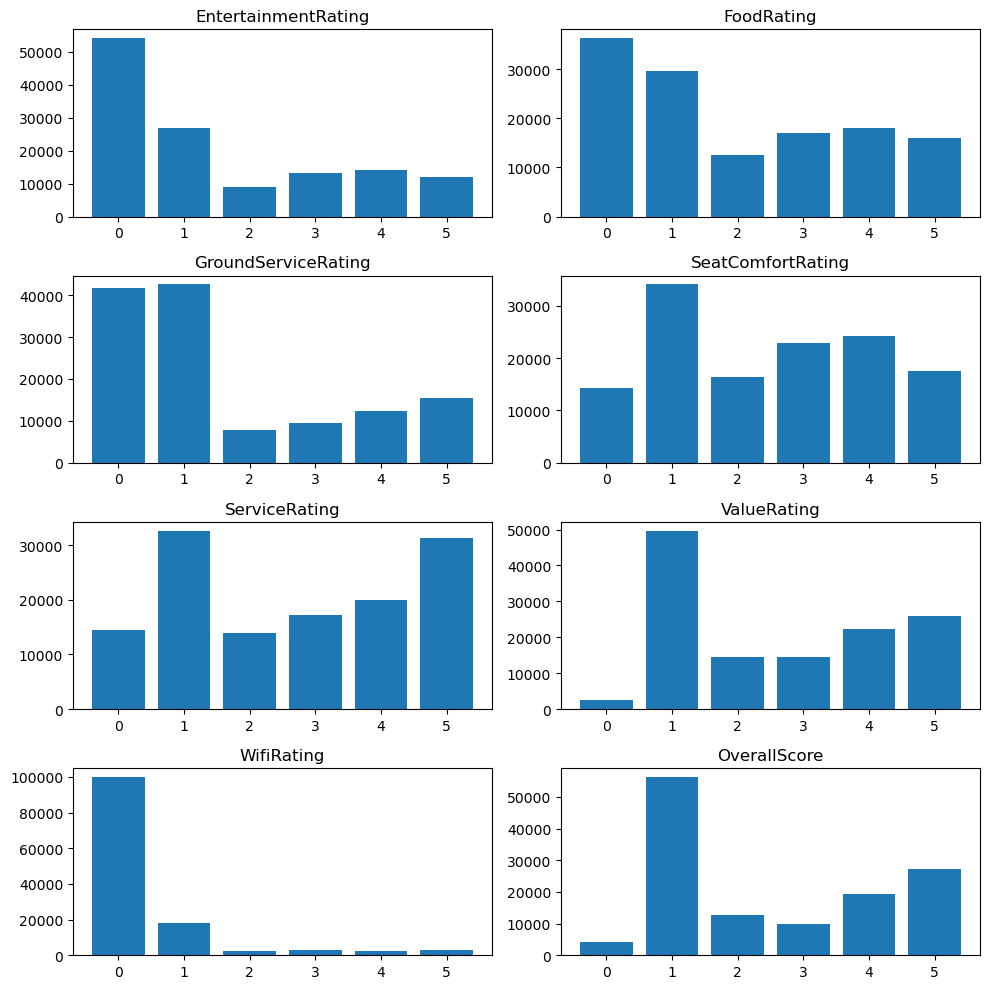

In [11]:
#Bar Chart to visualize the frequency of the ratings
fig, axes = plt.subplots(4, 2, figsize=(10, 10))
axes = axes.flatten()

for ax, col in zip(axes, rating_columns):
    counts = df[col].value_counts().sort_index()
    ax.bar(counts.index, counts.values)
    ax.set_title(col)

plt.tight_layout()
plt.show()

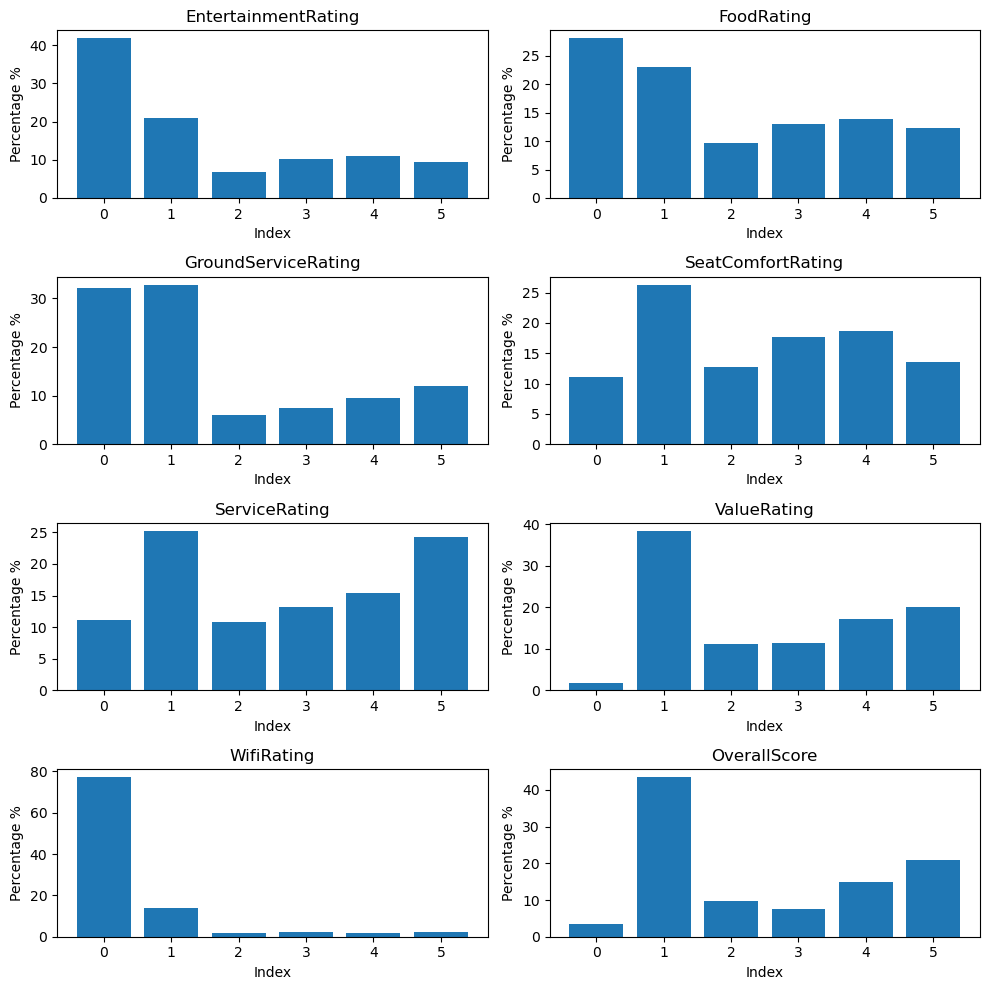

In [12]:
#Chart bar to visualize the frequency of ratings in percentage
fig, axes = plt.subplots(4, 2, figsize=(10, 10))
axes = axes.flatten()

for ax, col in zip(axes, rating_columns):
    counts = df[col].value_counts(normalize=True).sort_index()*100
    ax.bar(counts.index, counts.values)
    ax.set_title(col)
    ax.set_xlabel("Index")
    ax.set_ylabel("Percentage %")
    
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Overall Rating')

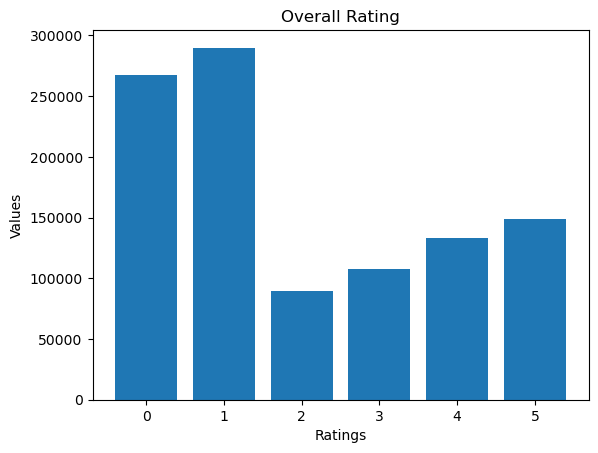

In [13]:
# Chart Bar to visualize the overall rating frequency
val=df[rating_columns].stack().value_counts().sort_index()
plt.figure
plt.bar(val.index, val.values)
plt.xlabel("Ratings")
plt.ylabel("Values")
plt.title("Overall Rating")

Text(0.5, 1.0, 'Overall Rating')

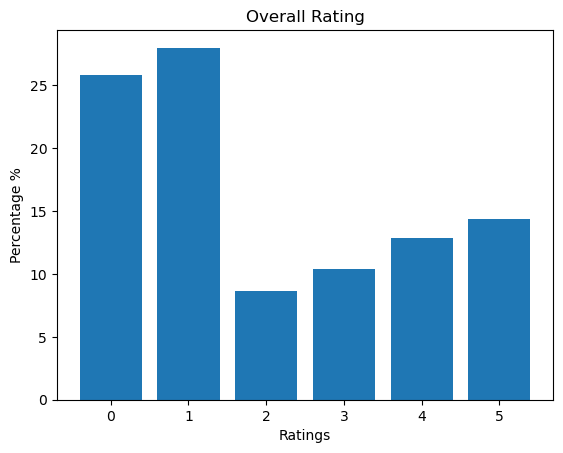

In [14]:
# Chart Bar to visualize the overall rating frequency in percentage
percentage=df[rating_columns].stack().value_counts(normalize=True).sort_index()*100
plt.figure
plt.bar(percentage.index, percentage.values)
plt.xlabel("Ratings")
plt.ylabel("Percentage %")
plt.title("Overall Rating")

In [15]:
#Add more 0 values to the ratings randomely around the dataset
columns_to_modify = ['OverallScore','SeatComfortRating', 'ServiceRating','ValueRating']
total_replace=50000
total_rows=df.shape[0]
total_columns=len(columns_to_modify)
total_cells=total_rows*total_columns
total_replace=min(total_replace, total_cells)
random_position=np.random.choice(total_cells, total_replace)
rows=random_position//total_columns
cols=random_position%total_columns
for r, c in zip(rows, cols):
    df.loc[r, columns_to_modify[c]]=0
    

In [16]:
#Check the ratings frequency
total_counts = df[rating_columns].stack().value_counts().sort_index()
print(total_counts,total_counts.sum())

0    311963
1    274067
2     84012
3    101419
4    124963
5    139216
Name: count, dtype: int64 1035640


Text(0.5, 1.0, 'Overall Rating')

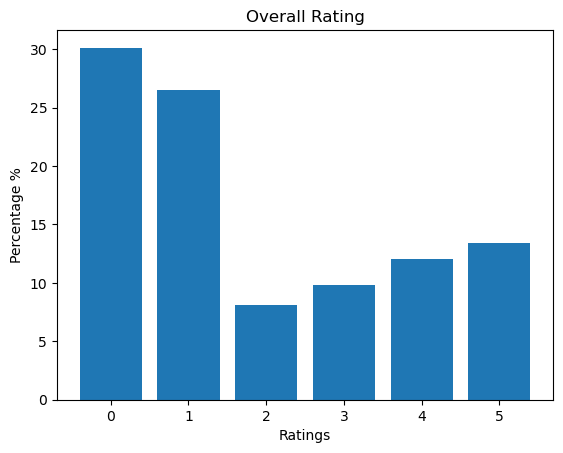

In [17]:
# Chart Bar to visualize the overall rating frequency in percentage
percentage=df[rating_columns].stack().value_counts(normalize=True).sort_index()*100
plt.figure
plt.bar(percentage.index, percentage.values)
plt.xlabel("Ratings")
plt.ylabel("Percentage %")
plt.title("Overall Rating")

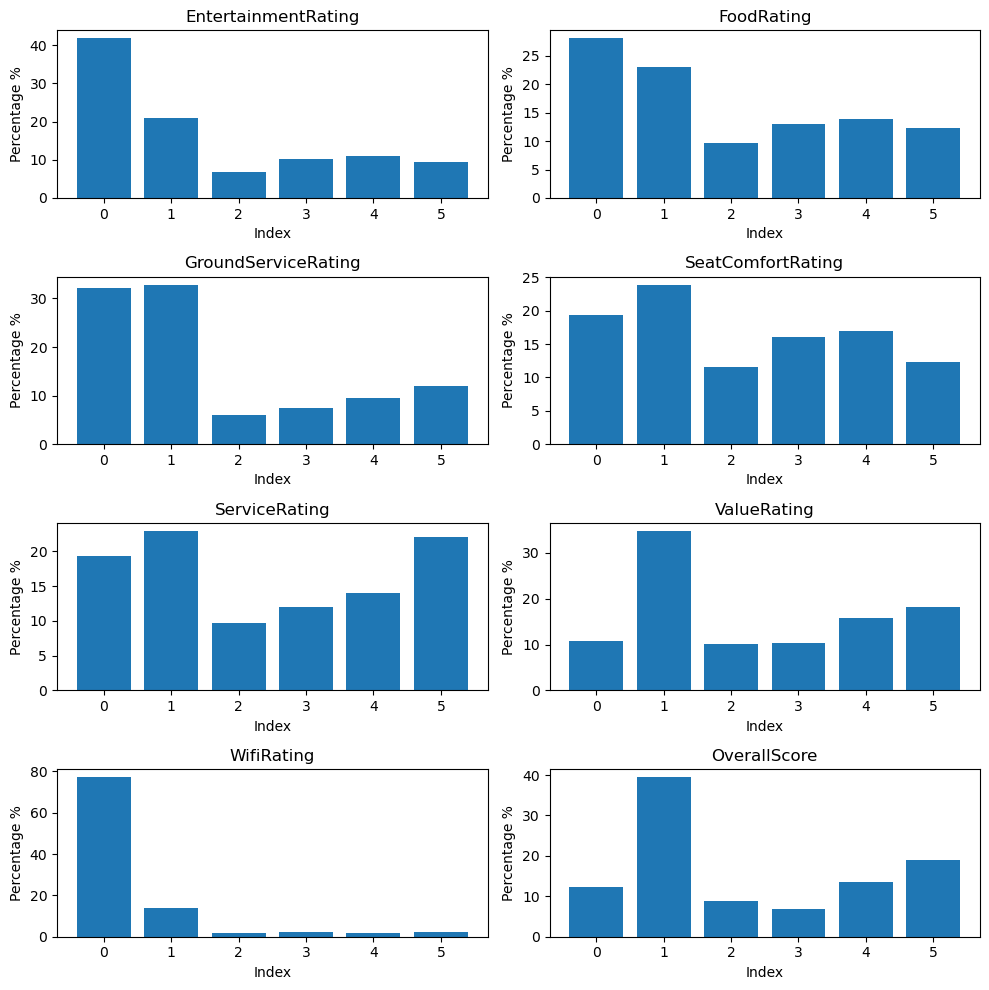

In [18]:
#Chart bar to visualize the frequency of ratings in percentage
fig, axes = plt.subplots(4, 2, figsize=(10, 10))
axes = axes.flatten()

for ax, col in zip(axes, rating_columns):
    counts = df[col].value_counts(normalize=True).sort_index()*100
    ax.bar(counts.index, counts.values)
    ax.set_title(col)
    ax.set_xlabel("Index")
    ax.set_ylabel("Percentage %")
    
plt.tight_layout()
plt.show()

In [19]:

df_text = df.copy()

# Make sure Review is string + remove empty/whitespace-only rows
df_text["Review"] = df_text["Review"].astype(str).str.strip()
df_text = df_text[df_text["Review"] != ""]

# Clean the data
def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-z0-9\s!?']", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df_text["Review"] = df_text["Review"].apply(clean_text)

# Tokenize into a NEW column (don’t overwrite Review)
def tokenize(text):
    return re.findall(r"\w+|[^\w\s]", text)

df_text["Tokens"] = df_text["Review"].apply(tokenize)


# Remove rows with empty token lists
df_text = df_text[df_text["Tokens"].apply(len) > 0]

# Now extract what you need for encoding/padding
review = df_text["Tokens"]
labels = df_text["Recommended"]
ratings = df_text[rating_columns]


In [20]:
# Normalize the ratings columns
ratings_norm=ratings/5
ratings_norm=np.array(ratings_norm)
ratings_norm

array([[0. , 0.8, 0.8, ..., 0.6, 0. , 1. ],
       [0. , 0.2, 0.2, ..., 0.4, 0. , 0.2],
       [0. , 0.2, 0.2, ..., 0.4, 0. , 0.2],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0.2],
       [0. , 0. , 0. , ..., 0.8, 0. , 0. ],
       [0. , 0. , 0. , ..., 0.2, 0. , 0.2]])

In [21]:
#Encode the text from the reviews and create the vocabulary
def encode(textual, labels):
    word_list=[]
    for sent in textual:
        for word in sent:
            word_list.append(word)
    word_count=Counter(word_list)
    word_sort=sorted(word_count, key=word_count.get, reverse=True)[:30000]
    encode={w:i+2 for i,w in enumerate(word_sort)}
    encode["UNK"]=1
    final_list=[]
    for sent in textual:
        final_list.append([encode.get(word, 1) for word in sent]) 
    label_encode=[1 if label=="YES" else 0 for label in labels]  
    return np.array(final_list, dtype=object), np.array(label_encode), encode






   

In [22]:
text, labels, vocab=encode(review, labels)

In [23]:
text.shape

(129453,)

In [24]:
print("The size of the vocab is",len(vocab))

The size of the vocab is 30001


In [25]:
vocab['UNK']

1

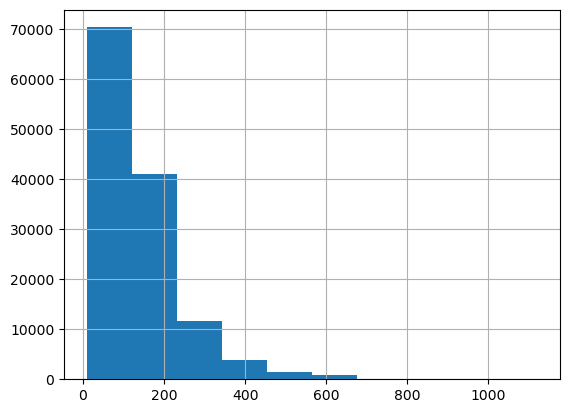

count    129453.000000
mean        140.108093
std         100.142527
min           9.000000
25%          72.000000
50%         112.000000
75%         175.000000
max        1121.000000
dtype: float64

In [26]:
#Check the sequence of all reviews with the hystogram
seq_len=[len(i) for i in text]
pd.Series(seq_len).hist()
plt.show()
pd.Series(seq_len).describe()

In [27]:
#Padding the sequences to be all equal
def padding_(sentences, seq_len):
    pad_sentences=[]
    for sequence in sentences:
        pad_sequence=sequence[:seq_len]+[0]*max(0, seq_len-len(sequence))
        pad_sentences.append(pad_sequence)
    return np.array(pad_sentences)
    
                     

In [28]:
text_padding=padding_(text, 250)

In [29]:
text_padding=text_padding.astype(int)

In [30]:
text_padding[10]

array([  796,   104,     7,  2550,  1337,     4,   104,    20,    75,
          13,  5826,    10,     2,   373,    27,  1028,     3, 13179,
           8,   846,  1563,    16,   333,    15,   110,     4,    12,
         187,   204,     8,     7,   337,   423,  1477,   278,  1004,
          16,    18,    20,   271,     3,  2834,    19,   498,   204,
         191,     2,   110,   146,    23,     2,   441,   578,  1595,
        6579,    12,   541,    16,  1300,    15,   697, 10876,    64,
           5,   157,   113,     9,    13,    72, 11704,  1057,   586,
       13179,     8,  1307,  1563,    16,   181,     2,     9,    13,
          29,   415,   631,    59,    99,     2,   202,  4077,   278,
        1004,     3,   100,    33,     3,    56,   327,  6898,   541,
         476,    18,    20,  1887,     5,    71,    97,    75,    64,
          13,  5826,   112,     7,  2417,    66,  1269,    10,    32,
        5826,    12,  1515,  8299,   122,   318,     0,     0,     0,
           0,     0,

In [31]:
#Spliting the data in train and test sets
from sklearn.model_selection import train_test_split
train_df, val_df, rating_df, rating_val, y_train, y_val=train_test_split(text_padding, ratings_norm, labels, test_size=0.2, random_state=42, shuffle=True)


In [32]:
#Creating the attention_mask so can the padded tokens to be ignored and also a mask for the ratings that are 0 or not
attention_mask = (torch.from_numpy(train_df) != 0).long()
attention_mask_test = (torch.from_numpy(val_df) != 0).long()
ratings_mask=(torch.from_numpy(rating_df) != 0).float()
ratings_mask_test=(torch.from_numpy(rating_val) != 0).float()

In [33]:
ratings_mask.shape

torch.Size([103562, 8])

In [34]:
attention_mask.shape

torch.Size([103562, 250])

In [35]:
rating_df.shape

(103562, 8)

In [36]:
# Create the data loader, train and test
train_data=TensorDataset(torch.from_numpy(train_df).long(), attention_mask, torch.from_numpy(rating_df).float(), ratings_mask, torch.from_numpy(y_train).long())
test_data=TensorDataset(torch.from_numpy(val_df).long(),attention_mask_test, torch.from_numpy(rating_val).float(), ratings_mask_test, torch.from_numpy(y_val).long())
train_loader=DataLoader(train_data, shuffle=True, batch_size=32)
test_loader=DataLoader(test_data, shuffle=False, batch_size=32)

In [37]:
# Checking the data loader
dataiter = iter(train_loader)
sample_x, sample_attention, sample_rating, sample_rating_mask, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n x', sample_x)
print('Sample input: \n y', sample_y)
print('Sample attention: \n',sample_attention)
print('Sample: \n', sample_rating_mask)

Sample input size:  torch.Size([32, 250])
Sample input: 
 x tensor([[ 504,  926,    3,  ...,    0,    0,    0],
        [9163,    3, 1328,  ...,    0,    0,    0],
        [   2,  173,   43,  ...,    0,    0,    0],
        ...,
        [ 601,   27, 2148,  ...,    0,    0,    0],
        [3393,   17,    2,  ...,    0,    0,    0],
        [ 136, 2381,   85,  ...,    0,    0,    0]])
Sample input: 
 y tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 1])
Sample attention: 
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Sample: 
 tensor([[0., 0., 1., 0., 0., 1., 0., 1.],
        [0., 0., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 

In [38]:
#Cheking for empty rows wich will be completed padded with 0
val_ids  = torch.from_numpy(val_df).long()
val_mask = (val_ids != 0).long()
print("Empty rows number:", (val_mask.sum(dim=1) == 0).sum().item())

Empty rows number: 0


In [39]:
# The encoded position class
class LearnedPositionEncodeing(nn.Module):
    def __init__(self, max_len: int, d_model: int, dropout: float = 0.1):
        super().__init__()
        
        self.pos_emb=nn.Embedding(max_len, d_model)
        self.dropout=nn.Dropout(dropout)
    def forward(self, x):
        
        B, T, D=x.size()
        position=torch.arange(T, device=x.device).unsqueeze(0)
        pos_encoding=self.pos_emb(position)
        x=x+pos_encoding
        return self.dropout(x)
        
        
       
    
    


In [40]:
# Creting the transformer class for classification
class ClassificationTransformer(nn.Module):
    def __init__(self, max_len, vocab_size: int, d_model=264, n_heads=6, n_layers=4, d_ff=2048, dropout=0.1, num_classes=2, pad_id=0):
        super().__init__()
        assert d_model%n_heads==0, "d_model must be divisible by n_heads"
        
        self.pad_id=pad_id
        self.token_emb=nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.pos_enc=LearnedPositionEncodeing(max_len, d_model, dropout=dropout)
        
        enc_layer=nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff, dropout=dropout, batch_first=True, norm_first=True)
        
        self.encoder=nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.norm=nn.LayerNorm(d_model)
        self.classifier=nn.Linear(280, num_classes)
        
    def masked_mean_pool(self, x: torch.Tensor, attention_mask: torch.Tensor):
        mask=attention_mask.unsqueeze(-1).to(dtype=x.dtype)
        x=x*mask
        denom=mask.sum(dim=1).clamp(min=1)
        pooled=x.sum(dim=1)/denom
        return pooled
        
    def forward(self, inputs, attention_mask, ratings, ratings_mask):
        x=self.token_emb(inputs)
        x=self.pos_enc(x)
        key_padding_mask = (attention_mask==0)
        h=self.encoder(x, src_key_padding_mask=key_padding_mask)
        h=self.norm(h)
        pooled=self.masked_mean_pool(h, attention_mask)
        finalX = torch.cat([pooled, ratings, ratings_mask], dim=1)  
        logits=self.classifier(finalX)
        return logits
        
        
        
        
        
        
        
        
    

In [41]:
# The evaluate function
@torch.no_grad()
def evaluate(model, data_loader, device, criterion, desc=None):
    model.eval()
    total_loss=0
    total_correct=0
    total_examples=0
    pbar=tqdm(data_loader, desc=desc) if desc else data_loader

     
        
    for inputs, attention_mask, ratings, ratings_mask,  labels in pbar:
        inputs=inputs.to(device)
        attention_mask=attention_mask.to(device)
        ratings=ratings.to(device)
        ratings_mask=ratings_mask.to(device)
        labels=labels.to(device)
        
        logits=model(inputs, attention_mask, ratings, ratings_mask)
        loss=criterion(logits, labels)

        batch_size=labels.size(0)
        total_loss+=loss.item() * batch_size
        
        preds=torch.argmax(logits, dim=1)
        total_correct += (preds==labels).sum().item()
        total_examples += batch_size
        
        
    average_loss=total_loss / max(1, total_examples)
    accuracy=total_correct / max(1, total_examples)

    return average_loss, accuracy
        
        
    

In [42]:
#The training Function
def train(model, train_loader, val_loader, device, epochs=5, lr=3e-4, weight_decay=0.01):
    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    hystory={"train_loss": [],
            "train_accuracy": [], 
            "val_loss": [], 
            "val_accuracy": []}
    best_value_accuracy=-1
    best_path="best_path.pt"
    
    for epoch in range(1, epochs+1):
        model.train()
        total_loss=0
        total_corect=0
        total_exemples=0
        pbar=tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        
        for inputs, attention_mask, ratings, ratings_mask, labels in pbar:
            inputs=inputs.to(device)
            attention_mask=attention_mask.to(device)
            ratings=ratings.to(device)
            ratings_mask=ratings_mask.to(device)
            labels=labels.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            logits=model(inputs, attention_mask, ratings, ratings_mask)
            loss=criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            batch_size=labels.size(0)
            total_loss+=loss.item()*batch_size
            
            pred=torch.argmax(logits, dim=-1)
            total_corect+=(pred==labels).sum().item()
            total_exemples+=batch_size
            avg_loss_so_far=total_loss/max(1, total_exemples)
            average_accuracy_so_far=total_corect/max(1, total_exemples)
            
        train_loss=total_loss/max(1, total_exemples)
        train_accuracy=total_corect/max(1, total_exemples)
        val_loss, val_accuracy = evaluate(model, val_loader, device, criterion, desc="Validation")
        
        hystory["train_loss"].append(train_loss)
        hystory["train_accuracy"].append(train_accuracy)
        hystory["val_loss"].append(val_loss)
        hystory["val_accuracy"].append(val_accuracy)
        print(f"Epoch: {epoch} Train Loss: {train_loss:.3f} Train Accuracy: {train_accuracy:.2f}, Val Loss: {val_loss:.3f}, Val Accuraccy: {val_accuracy:.3f}")
        if val_accuracy>best_value_accuracy:
            best_value_accuracy=val_accuracy
            torch.save({"model_state_dict":model.state_dict(), "best_val_acc": best_value_accuracy,}, best_path)
            print(f"Saved the best model to: {best_path} (val_acc={best_value_accuracy:.4f})")
        
    return hystory, best_path           
            
            
            
            
            
            
        
        

In [43]:
vocab_size=len(vocab)
max_len=train_df.shape[1]

In [44]:
#The classification model
model=ClassificationTransformer(max_len=max_len, vocab_size=vocab_size, d_model=264, n_heads=4, n_layers=2, d_ff=1024, dropout=0.1, num_classes=2, pad_id=0).to(device)

/Users/bogdanpetrus/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [45]:
print(model)

ClassificationTransformer(
  (token_emb): Embedding(30001, 264, padding_idx=0)
  (pos_enc): LearnedPositionEncodeing(
    (pos_emb): Embedding(250, 264)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=264, out_features=264, bias=True)
        )
        (linear1): Linear(in_features=264, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=264, bias=True)
        (norm1): LayerNorm((264,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((264,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((264,), eps=1e-05, elementwise_affine=True)
  (classifier): Linear(in_f

In [46]:
history, best_path = train(model, train_loader, test_loader, device, epochs=5, lr=3e-4)

Validation: 100%|██████████| 810/810 [00:09<00:00, 85.03it/s]


Epoch: 1 Train Loss: 0.249 Train Accuracy: 0.90, Val Loss: 0.177, Val Accuraccy: 0.929
Saved the best model to: best_path.pt (val_acc=0.9286)


Validation: 100%|██████████| 810/810 [00:10<00:00, 77.37it/s]


Epoch: 2 Train Loss: 0.155 Train Accuracy: 0.94, Val Loss: 0.144, Val Accuraccy: 0.946
Saved the best model to: best_path.pt (val_acc=0.9458)


Validation: 100%|██████████| 810/810 [00:10<00:00, 76.20it/s]


Epoch: 3 Train Loss: 0.130 Train Accuracy: 0.95, Val Loss: 0.137, Val Accuraccy: 0.945


Validation: 100%|██████████| 810/810 [00:10<00:00, 79.12it/s]


Epoch: 4 Train Loss: 0.116 Train Accuracy: 0.96, Val Loss: 0.133, Val Accuraccy: 0.947
Saved the best model to: best_path.pt (val_acc=0.9475)


Validation: 100%|██████████| 810/810 [00:10<00:00, 78.16it/s]

Epoch: 5 Train Loss: 0.105 Train Accuracy: 0.96, Val Loss: 0.146, Val Accuraccy: 0.945


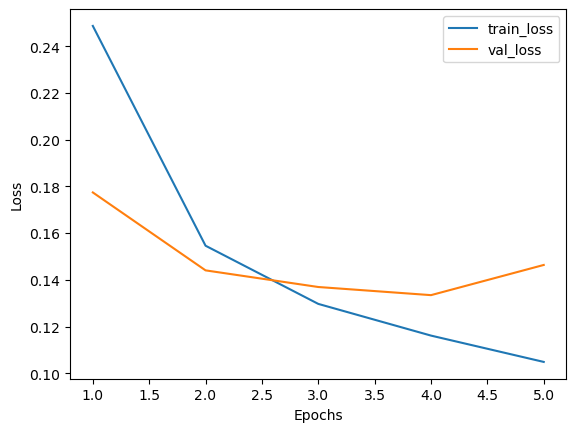

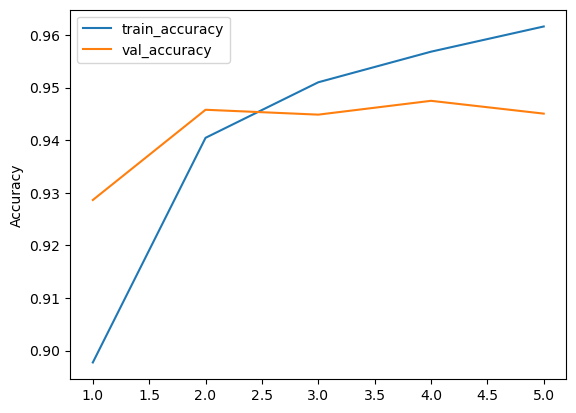

In [47]:
# Figures to visualize the training loss, test loss, training accuracy, test accuracy 
epochs=range(1, len(history["train_loss"])+1)
plt.figure()
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history["train_accuracy"], label="train_accuracy")
plt.plot(epochs, history["val_accuracy"], label="val_accuracy")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

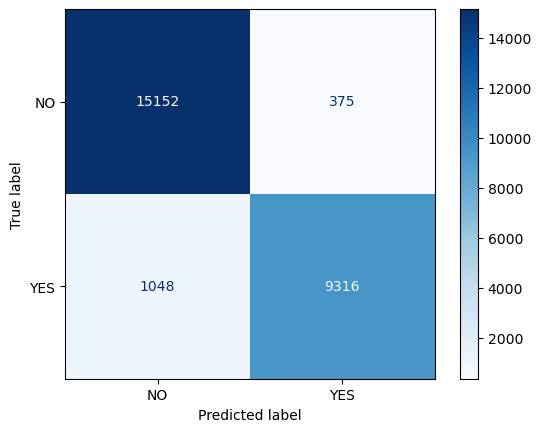

              precision    recall  f1-score   support

          NO       0.94      0.98      0.96     15527
         YES       0.96      0.90      0.93     10364

    accuracy                           0.95     25891
   macro avg       0.95      0.94      0.94     25891
weighted avg       0.95      0.95      0.94     25891



In [48]:
#Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
all_preds=[]
all_labels=[]
with torch.no_grad():
    for inputs,attention_mask, ratings, ratings_mask, labels in test_loader:
        inputs=inputs.to(device)
        labels=labels.to(device)
        ratings=ratings.to(device)
        ratings_mask=ratings_mask.to(device)
        
        attention_mask=attention_mask.to(device)
        logits=model(inputs, attention_mask, ratings, ratings_mask)
        preds=torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['NO', 'YES'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print classification report for additional metrics
print(classification_report(all_labels, all_preds, target_names=['NO', 'YES']))
        

In [49]:
#Prediction function to help classify any review with ratings
@torch.no_grad()
def predict(text, ratings):
    model.eval()
    text=str(text).strip()
    text=clean_text(text)
    text=tokenize(text)
    
    text=[vocab.get(tok, vocab.get('UNK')) for tok in text]
    text=text[:max_len]+[0] * max(0, max_len-len(text))
    attn_mask=[1 if t!=0 else 0 for t in text]
    
    input_ids = torch.tensor(text, dtype=torch.long, device=device).unsqueeze(0)          # (1, T)
    attention_mask=torch.tensor(attn_mask, dtype=torch.long, device=device).unsqueeze(0)
    ratings=np.array(ratings, dtype=np.float32)
    ratings_mask = (ratings!=0).astype(np.float32)
    
    ratings_norm=ratings/5
    input_ratings=torch.tensor(ratings_norm, dtype=torch.float32, device=device).unsqueeze(0)
    ratings_mask_torch=torch.tensor(ratings_mask, dtype=torch.float32, device=device).unsqueeze(0)
    
    logits=model(input_ids, attention_mask, input_ratings, ratings_mask_torch)
    
    percent=F.softmax(logits, dim=1)[0]
    pred_id=int(torch.argmax(percent).item())
    confidence = float(percent[pred_id].item()) * 100.0

    return pred_id, confidence
         
    

In [50]:
#Input of the reviews and ratings to be deploy trrough prediction function
print('Please write a review regarding your flight experience:')
print(" ")
index=input()
print(" ")
def rating(promt, lower=1, higher=5):
    while True:
        rating = input(promt)
        if rating=="":
            return 0
        elif rating.isdigit() and lower<=int(rating)<=higher:
            return int(rating)
        else:
             print(f'WRONG INPUT - Please enter a number from {lower} to {higher} or 0 if not applicable.')
        
index2 = rating('From 1 to 5 please rate the entertainment that you had on board or press ENTER if it is not applicable:')
index3 = rating('From 1 to 5 please rate the food that you had on board or press ENTER if it is not applicable:')
index4 = rating('From 1 to 5 please rate the ground service that you had or press ENTER if it is not applicable:')
index5 = rating('From 1 to 5 please rate the seat comfort that you had on board or press ENTER if it is not applicable:')
index6 = rating('From 1 to 5 please rate the service that you had on board or press ENETR if it is not applicable:')
index7 = rating('From 1 to 5 please rate the wi-fi that you had on board or press ENTER if it is not applicable:')
index8 = rating('From 1 to 5 please rate the value of your flight or press ENTER if it is not applicable:')
index9 = rating('From 1 to 5 please overall rate the value of your flight or press ENTER if it is not applicable:')        

ratings_list = [index2, index3, index4, index5, index6, index7, index8, index9]

pred, conf = predict(index, ratings_list)
if pred==1:
    recommend='YES'
else:
    recommend='NOT'


print(" ")
print(f"Entertainment - {index2}")
print(f"Food - {index3}")
print(f"Ground Service - {index4}")
print(f"Seat Comfort - {index5}")
print(f"Service on Board - {index6}")
print(f"Wi-Fi - {index7}")
print(f"Value of the Flight - {index8}")
print(f"Overall - {index9}")
print(" ")
print(f"The folowing review shows that the custumer will, {recommend}, recommend the airline with a probability of {conf:.3f}%")

Please write a review regarding your flight experience:
 


 Wizz air flight w95605 19/01/26 Gatwick to Jeddah flight was on time. Superb flight crews ahighly valued for their kindness, professionalism, resilience, and ability t attitudes, top-tier teams. Thank you for helping my wife she became unwell during flight. Thanks for helping her.


From 1 to 5 please rate the entertainment that you had on board or press ENTER if it is not applicable: 4
From 1 to 5 please rate the food that you had on board or press ENTER if it is not applicable: 4
From 1 to 5 please rate the ground service that you had or press ENTER if it is not applicable: 4
From 1 to 5 please rate the seat comfort that you had on board or press ENTER if it is not applicable: 4
From 1 to 5 please rate the service that you had on board or press ENETR if it is not applicable: 4
From 1 to 5 please rate the wi-fi that you had on board or press ENTER if it is not applicable: 4
From 1 to 5 please rate the value of your flight or press ENTER if it is not applicable: 4
From 1 to 5 please overall rate the value of your flight or press ENTER if it is not applicable: 4


 
Entertainment - 4
Food - 4
Ground Service - 4
Seat Comfort - 4
Service on Board - 4
Wi-Fi - 4
Value of the Flight - 4
Overall - 4
 
The folowing review shows that the custumer will, YES, recommend the airline with a probability of 99.375%
